# Image classification via fine-tuning with EfficientNet

**Author:** [Yixing Fu](https://github.com/yixingfu)<br>
**Date created:** 2020/06/30<br>
**Last modified:** 2020/07/16<br>
**Description:** Use EfficientNet with weights pre-trained on imagenet for Stanford Dogs classification.

# Experiment with Bilinear CNN
Bilinear CNN paper: http://vis-www.cs.umass.edu/bcnn/
With code from: https://github.com/NiFangBaAGe/FBCNN/blob/master/load_model.py

Self-connected Bilinear like Breast Cancer paper
https://www.frontiersin.org/articles/10.3389/fgene.2020.547327/full

Use Stanford Dogs. A subset of ImageNet-1k chosen for the task of fine-grained image categorization AKA texture AKA fluffiness.
https://www.tensorflow.org/datasets/catalog/stanford_dogs

Rotate the EfficientNet output vectors with PCA to create "meatier" feature vectors.

SHOULD THIS HAVE A SEPARATE PCA ROTATION FOR EVERY CONVOLUTION? 1280 CONVOLUTIONS, 1280 PCA SESSIONS? 

In [1]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

In [2]:
import gc
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from sklearn.decomposition import IncrementalPCA as PCA
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

gc.collect()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


0

In [3]:
import tensorflow_datasets as tfds

batch_size = 128

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteQUK337/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteQUK337/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


When the dataset include images with various size, we need to resize them into a
shared size. The Stanford Dogs dataset includes only images at least 200x200
pixels in size. Here we resize the images to the input size needed for EfficientNet.

In [4]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

### Visualizing the data

The following code shows the first 9 images with their labels.

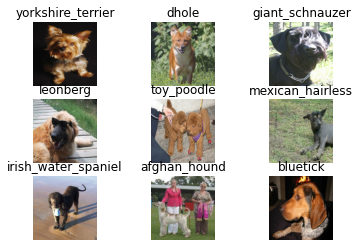

In [5]:
import matplotlib.pyplot as plt


def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")


### Data augmentation

We can use the preprocessing layers APIs for image augmentation.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

This `Sequential` model object can be used both as a part of
the model we later build, and as a function to preprocess
data before feeding into the model. Using them as function makes
it easy to visualize the augmented images. Here we plot 9 examples
of augmentation result of a given figure.

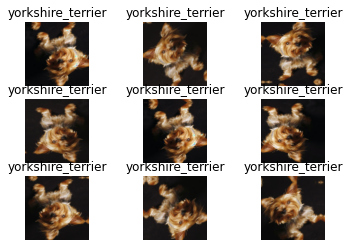

In [7]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")


### Prepare inputs

Once we verify the input data and augmentation are working correctly,
we prepare dataset for training. The input data are resized to uniform
`IMG_SIZE`. The labels are put into one-hot
(a.k.a. categorical) encoding. The dataset is batched.

Note: `prefetch` and `AUTOTUNE` may in some situation improve
performance, but depends on environment and the specific dataset used.
See this [guide](https://www.tensorflow.org/guide/data_performance)
for more information on data pipeline performance.

In [8]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)


A little code for plotting the results.

In [9]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


# plot_hist(hist)

# PCA Rotation Matrix
Create a PCA projection matrix from EfficientNetB0 vectors based on training dataset.

First, create a model that takes Stanford Dog training or test sets and projects them to the end of CNN pipeline, before the final classification top.

In [10]:
NUM_MAPS = 1280
MAP_SIZE = 7 * 7

def build_bare_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    eff = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    # Freeze the pretrained weights
    eff.trainable = False
    sub_model = tf.keras.Model(inputs, eff.output, name='effb0')
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = sub_model(inputs)
    x = layers.Reshape((MAP_SIZE, NUM_MAPS))(x)
    x = layers.Permute((2,1))(x)
    print(x.shape)

    # Compile
    model = tf.keras.Model(inputs, x, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model
# with strategy.scope():
bare_model = build_bare_model()
bare_model.summary()
pred1 = bare_model.predict(np.zeros((1, 224, 224, 3)))
print(pred1.shape)

16719872/16705208 [==============================] - 0s 0us/step
(None, 1280, 49)
Model: "EfficientNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 effb0 (Functional)          (None, 7, 7, 1280)        4049571   
                                                                 
 reshape (Reshape)           (None, 49, 1280)          0         
                                                                 
 permute (Permute)           (None, 1280, 49)          0         
                                                                 
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
_________________________________________________________________
(1, 1280, 49)


In [11]:
def plot_progress(deltas):
    x = np.array(range(len(deltas)), dtype='int32')
    y = np.asarray(deltas)
    #create basic scatterplot
    plt.plot(x, y, 'o')

    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(x, y, 1)

    #add linear regression line to scatterplot 
    plt.plot(x, m*x+b)

    # flush
    plt.show()

In [12]:
sample = None
prev_full = None
deltas = []
# gramdets = []
pca_set = []
for p in range(NUM_MAPS):
    pca_set.append(PCA(n_components=MAP_SIZE))

def run_pca(ds):
    global sample, prev_full, deltas, pca_set
    gc.collect()
    num_images = 0
    for (images, labels) in ds:
        gc.collect()
        # print(images.shape)
        pred = bare_model.predict(images)
        # print('raw pred shape', pred.shape)
        transp = pred.transpose((1,0,2))
        # print('transposed pred shape', transp.shape)
        if sample is None:
            sample = pred[0]
            print('sample:', sample.shape)
        for i in range(NUM_MAPS):
            maps = transp[i]
            # print('maps', maps.shape)
            pca_set[i].partial_fit(maps)
        # print('components[0]', pca_set[0].components_.shape)

        # Measure deltas of one projected sample across successive training rounds
        # Project every feature map in the sample
        # Save the mean Manhattan distance of all projected feature maps v.s. the previous set of feature maps 
        full = np.zeros((NUM_MAPS, MAP_SIZE))
        for i in range(NUM_MAPS):
            x = pca_set[i].transform(sample[i].reshape((-1, MAP_SIZE)))
            # if i == 0:
            #     print('x', x.shape)
            full[i, :] = x[:]
        if prev_full is not None:
            delta = np.mean(np.abs(prev_full - full))
            print('mean delta:', delta)
            deltas.append(delta)
        prev_full = full
        pred = None
        num_images = num_images + images.shape[0]
    print('num_images', num_images)


We're going to train the IncrementalPCA object to project embedding vectors to a new basis where the information is pushed toward one end of the vector. We will do several round of training using the entire training dataset. Each round uses a shuffled version of the dataset, which should assist with getting to a final PCA projection.

We will plot the mean delta across each sample during the training of IncrementalPCA. This shows that as the PCA is fine-tuned, the projection of the original sample jumps around less and less.

In [13]:
ident = np.eye(MAP_SIZE)
pca_list = [ident for x in range(NUM_MAPS)]

Mon Jun 13 02:09:56 UTC 2022
PCA batch 0
sample: (1280, 49)
mean delta: 0.26789099279336426
mean delta: 0.23404096798939636
mean delta: 0.2106314457677243
mean delta: 0.19701407197707865
mean delta: 0.17818891401025352
mean delta: 0.15907843493727453
mean delta: 0.148780568486723
mean delta: 0.13784699606407627
mean delta: 0.1321348929290398
mean delta: 0.11858321550161836
mean delta: 0.11325685756204024
mean delta: 0.09945966621539137
mean delta: 0.09685634022882217
mean delta: 0.09983051818645483
mean delta: 0.09187782819439
mean delta: 0.09021368992142177
mean delta: 0.08211084071548432
mean delta: 0.07603923207930824
mean delta: 0.07637522897888578
mean delta: 0.07198469887937921
mean delta: 0.0718713664803695
mean delta: 0.07008792548808906
mean delta: 0.06481866952017827
mean delta: 0.06374819860193112
mean delta: 0.0593330989428741
mean delta: 0.05701497917809934
mean delta: 0.05743256645251714
mean delta: 0.05856032932978139
mean delta: 0.05434459180431509
mean delta: 0.0558907

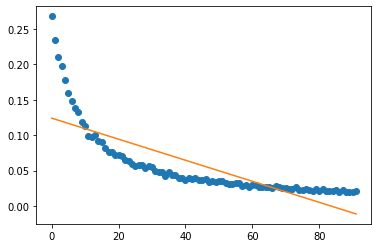

Mon Jun 13 02:15:22 UTC 2022
PCA batch 1
mean delta: 0.02005653826710004
mean delta: 0.019692861791105836
mean delta: 0.01782706939590484
mean delta: 0.01592055358352431
mean delta: 0.018059014341226948
mean delta: 0.01888861809300625
mean delta: 0.017575546639544203
mean delta: 0.017479117539211938
mean delta: 0.018056178139319163
mean delta: 0.01875780879628368
mean delta: 0.01727220485509587
mean delta: 0.01694960034178674
mean delta: 0.015441149267267728
mean delta: 0.015707053252246896
mean delta: 0.018049139363865957
mean delta: 0.017573682613513487
mean delta: 0.01756355599559534
mean delta: 0.016243374273663454
mean delta: 0.015056981181953102
mean delta: 0.01647161825030668
mean delta: 0.015805661225832733
mean delta: 0.017249621675321215
mean delta: 0.016374290542567758
mean delta: 0.015235754694575077
mean delta: 0.015014964503818562
mean delta: 0.0155027028784987
mean delta: 0.014276590719441732
mean delta: 0.015083877166958583
mean delta: 0.01620302444899951
mean delta: 0.

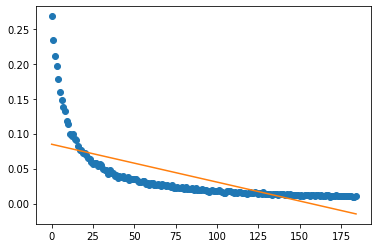

Mon Jun 13 02:20:45 UTC 2022
PCA batch 2
mean delta: 0.010057744753544704
mean delta: 0.010111208024828882
mean delta: 0.009449090563539134
mean delta: 0.009396276521654973
mean delta: 0.010061016741627595
mean delta: 0.009531331266611322
mean delta: 0.009007395010462148
mean delta: 0.009672511630823947
mean delta: 0.009676109481623387
mean delta: 0.009810890561740178
mean delta: 0.009219384314461673
mean delta: 0.00902016336227683
mean delta: 0.00805814195528771
mean delta: 0.008422906228175174
mean delta: 0.009960339516734642
mean delta: 0.00939575917360152
mean delta: 0.009932936620295941
mean delta: 0.009162009950326143
mean delta: 0.008351655051820462
mean delta: 0.008970107811341574
mean delta: 0.00886075679566306
mean delta: 0.009446937657917154
mean delta: 0.009898747210164515
mean delta: 0.008805248676316844
mean delta: 0.00940417227274201
mean delta: 0.008449952477824272
mean delta: 0.008441580187581513
mean delta: 0.00854421258004182
mean delta: 0.009330969932597173
mean del

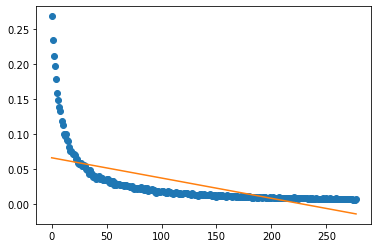

Mon Jun 13 02:26:08 UTC 2022
PCA batch 3
mean delta: 0.006932055592118174
mean delta: 0.006703177794812889
mean delta: 0.006450244613297499
mean delta: 0.005975318591486667
mean delta: 0.00675129710722008
mean delta: 0.006502004160495128
mean delta: 0.006036686581370919
mean delta: 0.006390493256496952
mean delta: 0.007303239222594435
mean delta: 0.006774636673325496
mean delta: 0.006822170849660596
mean delta: 0.006715914069262272
mean delta: 0.006287573483751366
mean delta: 0.0061899317258560125
mean delta: 0.006365115428520716
mean delta: 0.006441958123470831
mean delta: 0.00640952796035534
mean delta: 0.006545408828079959
mean delta: 0.006005946674889262
mean delta: 0.006344304893660304
mean delta: 0.005975297633645355
mean delta: 0.006232865817357569
mean delta: 0.006653164691964422
mean delta: 0.005854735822460561
mean delta: 0.006158406736436969
mean delta: 0.005967215530924374
mean delta: 0.005954855443678057
mean delta: 0.005766456828787086
mean delta: 0.0066046371700326295
me

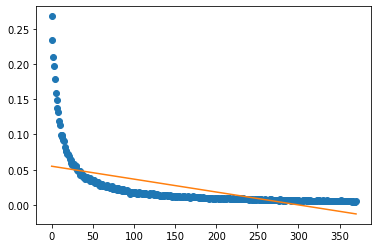

Mon Jun 13 02:31:30 UTC 2022
PCA batch 4
mean delta: 0.0051877370258170815
mean delta: 0.005079138657059044
mean delta: 0.004809442118762588
mean delta: 0.004735585433980201
mean delta: 0.004969021659988091
mean delta: 0.004967418329959395
mean delta: 0.004164065158527504
mean delta: 0.004917140937969001
mean delta: 0.005134073894567535
mean delta: 0.005184925708892321
mean delta: 0.005216770792367342
mean delta: 0.0043235269762716124
mean delta: 0.004728178688576858
mean delta: 0.004630070780726983
mean delta: 0.005550475901761781
mean delta: 0.004984500307420103
mean delta: 0.005033955600341308
mean delta: 0.005100411832087974
mean delta: 0.004793856502604968
mean delta: 0.004488667426781032
mean delta: 0.00458801194367105
mean delta: 0.005010581690953263
mean delta: 0.005203140524603994
mean delta: 0.004246213422585076
mean delta: 0.00519862539858127
mean delta: 0.004646481056794507
mean delta: 0.004469829029382348
mean delta: 0.004513675515156057
mean delta: 0.005137123423150759
me

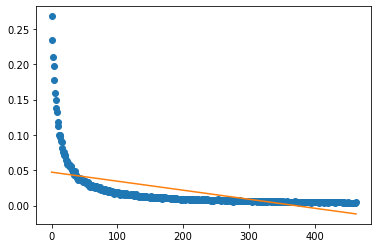

Mon Jun 13 02:37:53 UTC 2022
PCA batch 5
mean delta: 0.004294152014266651
mean delta: 0.003999419205711122
mean delta: 0.003631403311003387
mean delta: 0.0038759458727034373
mean delta: 0.003814716358872482
mean delta: 0.004299703358953759
mean delta: 0.004181941044514794
mean delta: 0.003979659913202016
mean delta: 0.004079649257615552
mean delta: 0.004167038421419786
mean delta: 0.00395622014862034
mean delta: 0.003591335521208563
mean delta: 0.003387618167665641
mean delta: 0.00427402428288481
mean delta: 0.004681690931225219
mean delta: 0.00440217269430188
mean delta: 0.004475170969073357
mean delta: 0.004279963854239612
mean delta: 0.003636216051812771
mean delta: 0.004046098132569698
mean delta: 0.0042568618938567376
mean delta: 0.004133733842994822
mean delta: 0.003712816648834884
mean delta: 0.003729422335503997
mean delta: 0.003951538843196771
mean delta: 0.0037660891013130042
mean delta: 0.003739283883604925
mean delta: 0.0035711785258961105
mean delta: 0.004737475589625857
m

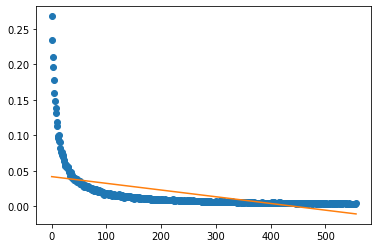

Mon Jun 13 02:43:15 UTC 2022
PCA batch 6
mean delta: 0.0037260461747187453
mean delta: 0.003364294490171973
mean delta: 0.0030457934891025464
mean delta: 0.0033284789375015813
mean delta: 0.0032671380904249004
mean delta: 0.0037159383062043212
mean delta: 0.003671919400405751
mean delta: 0.00345369736628839
mean delta: 0.00341861666339758
mean delta: 0.0031239148827610615
mean delta: 0.0037411722129143798
mean delta: 0.0031514008169482807
mean delta: 0.0025874536060084127
mean delta: 0.0038132342722587025
mean delta: 0.004120275455498038
mean delta: 0.003884286502200298
mean delta: 0.003979690357191352
mean delta: 0.003846209547055622
mean delta: 0.0029830633233639855
mean delta: 0.002963849710051255
mean delta: 0.003431070222721438
mean delta: 0.0033446390705793774
mean delta: 0.003046206944711226
mean delta: 0.003133896792332356
mean delta: 0.0035047265967234616
mean delta: 0.0029582815722613443
mean delta: 0.003096686370015234
mean delta: 0.0030249665181322893
mean delta: 0.00356022

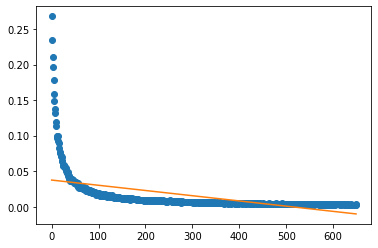

Mon Jun 13 02:48:38 UTC 2022
PCA batch 7
mean delta: 0.0031055765486953735
mean delta: 0.0027946443585068585
mean delta: 0.0026133608925693118
mean delta: 0.0026997045800632885
mean delta: 0.0032794832233046614
mean delta: 0.003303164760345454
mean delta: 0.0026507932518601155
mean delta: 0.002987930549561514
mean delta: 0.002983696496209851
mean delta: 0.0028443253001953976
mean delta: 0.003107142293272103
mean delta: 0.002831616318467387
mean delta: 0.002543829683772091
mean delta: 0.0031315864285665226
mean delta: 0.0033917224678656757
mean delta: 0.003390080468288075
mean delta: 0.0031704702294822556
mean delta: 0.003329908996882859
mean delta: 0.00313636721489085
mean delta: 0.003103169388175742
mean delta: 0.0035558956329728854
mean delta: 0.0029353511766385086
mean delta: 0.002507835957345964
mean delta: 0.0025471589463983723
mean delta: 0.002910834534715434
mean delta: 0.002432314483502664
mean delta: 0.0028216832207584508
mean delta: 0.0024391467435615115
mean delta: 0.0029244

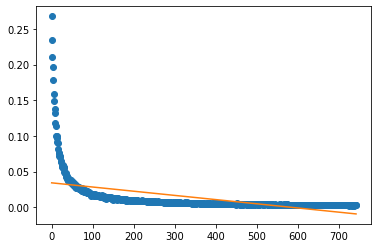

Mon Jun 13 02:54:00 UTC 2022
PCA batch 8
mean delta: 0.002816164315847929
mean delta: 0.002287136908157973
mean delta: 0.002504324715597414
mean delta: 0.002381283278480112
mean delta: 0.003088573384907427
mean delta: 0.0030759476643817986
mean delta: 0.0023262888234265493
mean delta: 0.0027351128922441415
mean delta: 0.0028361891737785946
mean delta: 0.002711424977075705
mean delta: 0.0026177665026057844
mean delta: 0.002431412247373207
mean delta: 0.002293666898761944
mean delta: 0.0025650426932757107
mean delta: 0.0030447567778860043
mean delta: 0.002767710907712465
mean delta: 0.0024953540265495767
mean delta: 0.002779949159311193
mean delta: 0.002528068302671788
mean delta: 0.002284959228529091
mean delta: 0.002667544709132433
mean delta: 0.002693945710283318
mean delta: 0.002264452136018987
mean delta: 0.0020432946519860326
mean delta: 0.0027295401245154695
mean delta: 0.0020048764323225537
mean delta: 0.002267878856213247
mean delta: 0.002130998545371032
mean delta: 0.0026122413

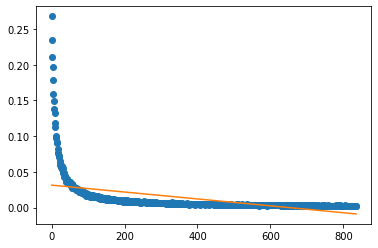

Mon Jun 13 02:59:23 UTC 2022
PCA batch 9
mean delta: 0.0025476686807168547
mean delta: 0.002110310674866223
mean delta: 0.002236079682375724
mean delta: 0.0023789269851170955
mean delta: 0.002391885673744328
mean delta: 0.0026067228175048573
mean delta: 0.002162219097205833
mean delta: 0.0025647081692311124
mean delta: 0.002535524976006786
mean delta: 0.0024504145699240937
mean delta: 0.002191280560334532
mean delta: 0.0024004644958999666
mean delta: 0.0017934511107173957
mean delta: 0.0023060442283224384
mean delta: 0.0025927387118254777
mean delta: 0.0022342998963078642
mean delta: 0.002175750496426695
mean delta: 0.0025688268179341186
mean delta: 0.0022413745687714865
mean delta: 0.0018682549589873437
mean delta: 0.002436589079317195
mean delta: 0.002257209924278997
mean delta: 0.002103973786896058
mean delta: 0.0019933665104078686
mean delta: 0.0023559336128569936
mean delta: 0.0020033618827386833
mean delta: 0.002034353938517312
mean delta: 0.0019270430732859286
mean delta: 0.0023

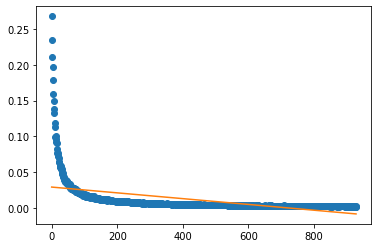

Mon Jun 13 03:04:40 UTC 2022
PCA batch 10
mean delta: 0.0023194282303388722
mean delta: 0.0019474313305537683
mean delta: 0.002153703849461734
mean delta: 0.0021732832147231575
mean delta: 0.00205270701849584
mean delta: 0.002326039730811042
mean delta: 0.002248141445388372
mean delta: 0.0023419830056040924
mean delta: 0.002300934814490115
mean delta: 0.0021485433057396213
mean delta: 0.0018987877491259554
mean delta: 0.0020040362364166673
mean delta: 0.0019197324600771595
mean delta: 0.002026365762060655
mean delta: 0.0022834176048157706
mean delta: 0.002140300977685427
mean delta: 0.002060383002218165
mean delta: 0.002246023262278378
mean delta: 0.0019896407479482237
mean delta: 0.0017656875564703825
mean delta: 0.0019208663511152187
mean delta: 0.00209903907587006
mean delta: 0.0020899884210652626
mean delta: 0.001762663045101303
mean delta: 0.002149961345872051
mean delta: 0.0020317166074874256
mean delta: 0.001956832466679495
mean delta: 0.0017328542187325948
mean delta: 0.0020154

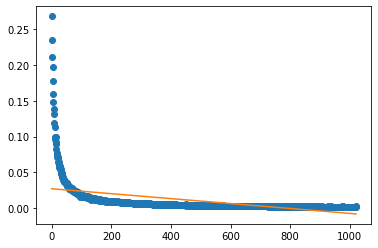

Mon Jun 13 03:10:02 UTC 2022
PCA batch 11
mean delta: 0.002093172950574403
mean delta: 0.0016655217949380153
mean delta: 0.0018677006503273745
mean delta: 0.002107112769578421
mean delta: 0.0019661018165539794
mean delta: 0.0020974125482872644
mean delta: 0.00202670581084996
mean delta: 0.0020120348822665274
mean delta: 0.0021386040128823997
mean delta: 0.0019197629887816887
mean delta: 0.0016364389518669395
mean delta: 0.001944196944285348
mean delta: 0.001918103719092998
mean delta: 0.0018993639642366986
mean delta: 0.0020820224943499856
mean delta: 0.0021255018303268217
mean delta: 0.0017995057453210025
mean delta: 0.0022628172736250873
mean delta: 0.0019803792214417846
mean delta: 0.0016193148616354626
mean delta: 0.001641217886308907
mean delta: 0.0017050866970136234
mean delta: 0.0017926401070400885
mean delta: 0.0015281689560309008
mean delta: 0.001948568986594718
mean delta: 0.0021215175833943028
mean delta: 0.0017210838538348127
mean delta: 0.0015539599523581222
mean delta: 0.

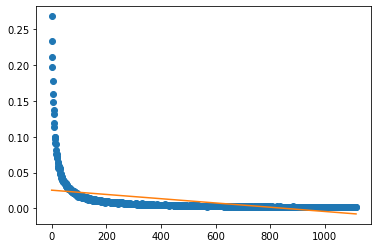

Mon Jun 13 03:15:18 UTC 2022
PCA batch 12
mean delta: 0.0019182351614563408
mean delta: 0.0015608435302259154
mean delta: 0.0016824244708087159
mean delta: 0.0019827500187593558
mean delta: 0.0018389360549084242
mean delta: 0.0019236799286740088
mean delta: 0.001934046641184817
mean delta: 0.0018579242119309675
mean delta: 0.0020136859501515493
mean delta: 0.0019195735690816622
mean delta: 0.0015233870788870319
mean delta: 0.0016252006152318343
mean delta: 0.001549767434768144
mean delta: 0.0015406723512802836
mean delta: 0.0018526885068780418
mean delta: 0.0018319319640784481
mean delta: 0.0015480326158589504
mean delta: 0.0020018996844817258
mean delta: 0.0018489704922020084
mean delta: 0.001555084393513358
mean delta: 0.0015148975570371925
mean delta: 0.001582934519186928
mean delta: 0.0016339565268184758
mean delta: 0.001624913525499934
mean delta: 0.0014041721595324046
mean delta: 0.0018528973738259204
mean delta: 0.0014595207452287845
mean delta: 0.0014296619831905522
mean delta:

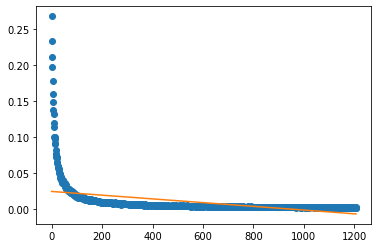

Mon Jun 13 03:20:34 UTC 2022
PCA batch 13
mean delta: 0.0017988086186724334
mean delta: 0.0015061178359387754
mean delta: 0.0014347176940353844
mean delta: 0.001728269563599232
mean delta: 0.0015389689222560583
mean delta: 0.0018160608670636268
mean delta: 0.0014879939412233735
mean delta: 0.0016054807990223588
mean delta: 0.0018797836925251693
mean delta: 0.0016056423874522077
mean delta: 0.0014662849902717788
mean delta: 0.0014961687404084689
mean delta: 0.001388903700067745
mean delta: 0.001486195103166584
mean delta: 0.001766193978207401
mean delta: 0.0017622717682708095
mean delta: 0.0014172049263027643
mean delta: 0.0017755487338931468
mean delta: 0.0018978459037011122
mean delta: 0.001697616019962066
mean delta: 0.001419086375568091
mean delta: 0.001653791308243878
mean delta: 0.0014037807105769927
mean delta: 0.0013343226782610124
mean delta: 0.001294051136621918
mean delta: 0.0014938610098328444
mean delta: 0.0012248318599183215
mean delta: 0.001572040263314392
mean delta: 0.0

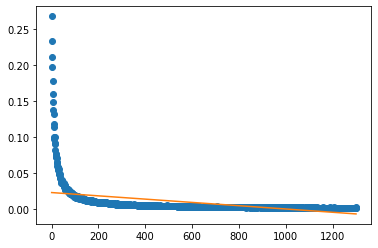

Mon Jun 13 03:25:57 UTC 2022
PCA batch 14
mean delta: 0.0016416787518569581
mean delta: 0.0013564493527622001
mean delta: 0.0013827987049910948
mean delta: 0.0015436059529890288
mean delta: 0.0014688453595030708
mean delta: 0.0016185701045709408
mean delta: 0.0014047900388627795
mean delta: 0.001361206458245015
mean delta: 0.0015254196931850073
mean delta: 0.0015217979548983677
mean delta: 0.0012855133703099956
mean delta: 0.0013555432752332646
mean delta: 0.001189474527370983
mean delta: 0.001419155014179667
mean delta: 0.0016507480126426786
mean delta: 0.0016305565105315094
mean delta: 0.001348146435817961
mean delta: 0.0016530028148191516
mean delta: 0.00177375124999284
mean delta: 0.0014210437149943115
mean delta: 0.001547853273749975
mean delta: 0.001603792558839747
mean delta: 0.0014206709411370708
mean delta: 0.0013173520494606753
mean delta: 0.0012137622753635154
mean delta: 0.001476022541930555
mean delta: 0.0011578166478883694
mean delta: 0.001354274302707089
mean delta: 0.00

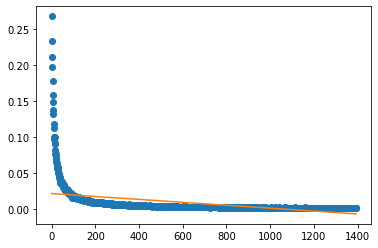

Mon Jun 13 03:31:19 UTC 2022
PCA batch 15
mean delta: 0.0015635996367967613
mean delta: 0.0011863403110789642
mean delta: 0.0013096146995983506
mean delta: 0.0014517612993379509
mean delta: 0.0013577652833183182
mean delta: 0.001468786745658105
mean delta: 0.0013337452744387464
mean delta: 0.001224584013930993
mean delta: 0.001407950673099942
mean delta: 0.0013783205154907783
mean delta: 0.0012370737675503334
mean delta: 0.0012376227460088895
mean delta: 0.0010358768304630974
mean delta: 0.0012573987949971814
mean delta: 0.001530024651950161
mean delta: 0.0015328972526094
mean delta: 0.0012299135757029359
mean delta: 0.001560999727317165
mean delta: 0.0014818611989580778
mean delta: 0.0013149984189414652
mean delta: 0.0014768166718140594
mean delta: 0.001414599970620756
mean delta: 0.0014540987971254412
mean delta: 0.0014070421338979794
mean delta: 0.0011189911210687385
mean delta: 0.0013067068671171287
mean delta: 0.00122294374249333
mean delta: 0.0013679160494847289
mean delta: 0.001

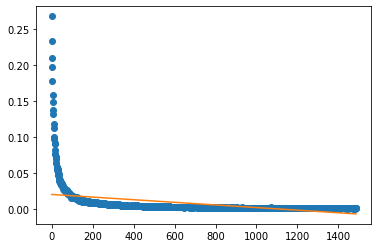

Mon Jun 13 03:36:35 UTC 2022
PCA batch 16
mean delta: 0.0014887684026991083
mean delta: 0.0010858214042198675
mean delta: 0.0011152109099058889
mean delta: 0.0012666246769210414
mean delta: 0.0013569808025944963
mean delta: 0.0011779225223856609
mean delta: 0.0009792217895918279
mean delta: 0.0011198481154331566
mean delta: 0.0012357692904762369
mean delta: 0.0013563471086752582
mean delta: 0.0011460102130444803
mean delta: 0.0012109830140575298
mean delta: 0.0010149783308744246
mean delta: 0.0009748025627213976
mean delta: 0.001513978769371928
mean delta: 0.0013435834218404673
mean delta: 0.0013504962783068147
mean delta: 0.0014963973322057425
mean delta: 0.0013060623945273786
mean delta: 0.0013668889589120738
mean delta: 0.0012486231442771798
mean delta: 0.0013195469085105617
mean delta: 0.0013196180166450244
mean delta: 0.001385572115592857
mean delta: 0.00104558229125603
mean delta: 0.0011343722846491014
mean delta: 0.00119113266201372
mean delta: 0.0010617278493504924
mean delta: 

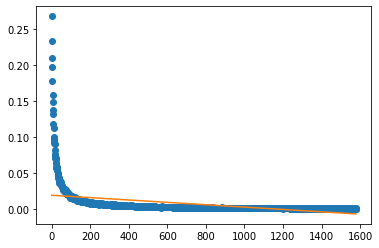

Mon Jun 13 03:41:58 UTC 2022
PCA batch 17
mean delta: 0.0013927047904329225
mean delta: 0.0009262783249939959
mean delta: 0.0010741719561120828
mean delta: 0.00121574158114041
mean delta: 0.0013482269164547052
mean delta: 0.001092914113976623
mean delta: 0.0009182326860948658
mean delta: 0.0011054164228719713
mean delta: 0.0013331282162183033
mean delta: 0.0013028270967269928
mean delta: 0.0011376895961952667
mean delta: 0.0011140213584207273
mean delta: 0.001014983666517956
mean delta: 0.001016877603133126
mean delta: 0.0014818906551117357
mean delta: 0.0011830789580949666
mean delta: 0.0012315228658306536
mean delta: 0.0014784439417046932
mean delta: 0.0013245234304574201
mean delta: 0.0012524614029533095
mean delta: 0.001211756471146704
mean delta: 0.0012575464249442903
mean delta: 0.0012466045783325846
mean delta: 0.0012770364344633336
mean delta: 0.001142946967158269
mean delta: 0.0011005684053157184
mean delta: 0.0009832588596777746
mean delta: 0.0010159140034192598
mean delta: 0

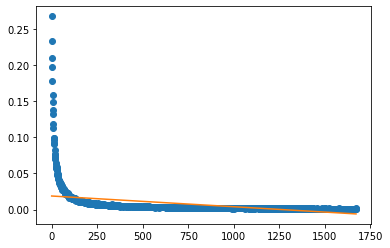

Mon Jun 13 03:47:14 UTC 2022
PCA batch 18
mean delta: 0.0013103536509847912
mean delta: 0.0008991996885562018
mean delta: 0.0010322518318471102
mean delta: 0.0012163778300010937
mean delta: 0.0012787387778170369
mean delta: 0.0010596340259353247
mean delta: 0.0008781960949139205
mean delta: 0.001003823023340436
mean delta: 0.0011617951107744722
mean delta: 0.001111590261548736
mean delta: 0.0010839848696625198
mean delta: 0.0010429556590022446
mean delta: 0.0009624347726105753
mean delta: 0.0010583241293275554
mean delta: 0.0013726479755195526
mean delta: 0.0011373588051779837
mean delta: 0.0010423916431091013
mean delta: 0.00135205314261463
mean delta: 0.0012028653973367377
mean delta: 0.001053431187389927
mean delta: 0.0013096897402035544
mean delta: 0.001212001992289122
mean delta: 0.0011772194213588068
mean delta: 0.0010675886394652303
mean delta: 0.001035057394206836
mean delta: 0.0010835601618827554
mean delta: 0.0009714273188449751
mean delta: 0.001077308399890317
mean delta: 0.

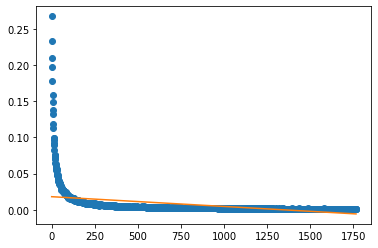

Mon Jun 13 03:52:31 UTC 2022
PCA batch 19
mean delta: 0.0012326943146436992
mean delta: 0.0008883080243562734
mean delta: 0.0010637149220919064
mean delta: 0.0010656892625306924
mean delta: 0.0012815657767214126
mean delta: 0.0010324799708505894
mean delta: 0.0009226986139775529
mean delta: 0.0009261480847202511
mean delta: 0.0011704344718241775
mean delta: 0.0010319511832233823
mean delta: 0.0010210810526549354
mean delta: 0.0010810558580481994
mean delta: 0.0008571467016322355
mean delta: 0.0010595023747771355
mean delta: 0.0013420910934655644
mean delta: 0.0010735556128620262
mean delta: 0.0011252001374922138
mean delta: 0.0012333547537391619
mean delta: 0.0010799743085669181
mean delta: 0.0010908230817252187
mean delta: 0.00118433611896102
mean delta: 0.0010621829401481504
mean delta: 0.0011220719718091838
mean delta: 0.0010416085949357485
mean delta: 0.0009206953026599747
mean delta: 0.0010596890185622584
mean delta: 0.0008367747958043023
mean delta: 0.0010157282687539599
mean del

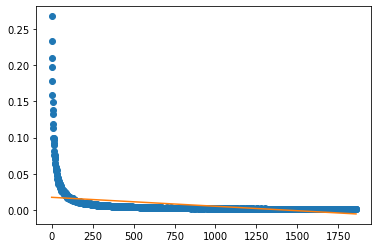

matrix.shape: (49, 49)
total samples: 238080
1280
(49, 49)
Mon Jun 13 03:57:49 UTC 2022


In [14]:
NUM_BATCHES = 20
for x in range(NUM_BATCHES):
    !date
    print('PCA batch %d' % x)
    run_pca(ds_train)
    plot_progress(deltas)
if NUM_BATCHES > 0:
    print('matrix.shape:', pca_set[0].components_.shape)
    print('total samples:', pca_set[0].n_samples_seen_)
    pca_list = [pca_set[x].components_ for x in range(len(pca_set))]
    print(len(pca_list))
    print(pca_list[0].shape)
!date

Now that we have a fully trained PCA object, let's plot the classic display of what PCA is all about. PCA projects an N-dimensional space such that the members of the 0-th cell of the output vector has the highest standard deviation, the 1-th cell the second highest stdev, etc.

(128, 1280, 49)
(49, 1280)
(49,)


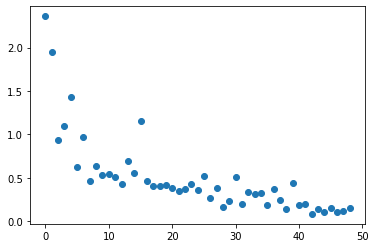

In [15]:
for (images, labels) in ds_train:
    pred = bare_model.predict(images)
    break
print(pred.shape)
projected = pca_set[0].transform(pred[0])
pred = None
transp = np.transpose(projected)
print(transp.shape)
std = np.ndarray.std(transp, axis=-1)
print(std.shape)
x = np.array(range(std.shape[0]), dtype='int32')
y = np.asarray(std)
#create basic scatterplot
plt.plot(x, y, 'o')

What this means for our purposes is that we have "concentrated" the variation between embeddings into a smaller set of numbers.

# Bilinear CNN
This layer creates a matrix where the columns are the channel values for all feature maps, and the rows are height X width of the feature maps. It then creates the 'outer product' of the matrix multiplied against itself.

In [16]:
!pip install -q -U git+https://github.com/LanceNorskog/keras-fbcnn.git
from keras_fbcnn import BilinearCNN1D

## Trained embeddings from pre-trained weights

---



Here we initialize the model with pre-trained ImageNet weights,
and we fine-tune it on our own dataset. We do three different trainings:


1.   Train a standard Global-Average-Pooling top
2.   Train a simple top using a Bilinear layer
3.   Train a simple top using PCA to project the EfficientNetB0 embeddings to a more "concentrated" vector space
4.   Create N PCA projectors, one per feature map
5.   Load these into a custom projector layer




In [17]:
""" Given a set of PCA matrices, project a set of input embeddings via each matrix """
class Projector1D(tf.keras.layers.Layer):
    def __init__(self, pca_list, components=None, **kwargs):
        self.pca_list = pca_list
        self.components = components
        super(Projector1D, self).__init__(**kwargs)

    def build(self, input_shape):
        print('build')
        n_projections = input_shape[-2]
        fmap_size = input_shape[-1]
        if self.components is not None:
            mats = np.zeros((n_projections, self.components, fmap_size), dtype='float32')
            for i in range(n_projections):
                mats[i][:,:] = self.pca_list[i][0:self.components, :]
            self.projectors = tf.Variable(mats, dtype='float32')
        else:
            self.projectors = tf.Variable(self.pca_list, dtype='float32')
        print('projectors', self.projectors)

    def call(self, inputs):
            
        print('call')
        shape = inputs.shape.as_list()
        print('shape:', shape)
        num_fmaps = shape[1]
        fmap_size = shape[2]
        # print('num_fmaps:', num_fmaps)
        # print('fmap_size:', fmap_size)
        output_shape = tf.TensorSpec((None, num_fmaps, fmap_size))
        # print('output_shape', output_shape)
 
        # create N copies of the projectors. Need a strategy for short batch?
        projectors_t = tf.stack([self.projectors for x in range(batch_size)])
        # print('projectors_t', projectors_t.shape)
        projected = tf.linalg.matvec(projectors_t, inputs, name='projector')

        return projected
  

In [18]:

def build_model(num_classes, bilinear=False, pca_list=None):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    eff = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    # Freeze the pretrained weights
    eff.trainable = False
    sub_model = tf.keras.Model(inputs, eff.output, name='effb0')
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = sub_model(inputs)

    # Build either bilinear or classic global-average-pooling top
    if bilinear and pca_list is not None:
        print('pca_list[0].shape', pca_list[0].shape)
        x_shape = x.shape
        print(x_shape)
        x = layers.Flatten()(x)
        x = layers.Reshape((MAP_SIZE, NUM_MAPS))(x)
        x = layers.Permute((2, 1))(x)
        projector = Projector1D(pca_list, components=16)
        x = projector(x)
        print('projected.shape', x.shape)
        projector.trainable = False
        x = layers.Permute((2, 1))(x)
        x = BilinearCNN1D()([x, x])
    elif bilinear:
        x = layers.Reshape((MAP_SIZE, NUM_MAPS))(x) 
        # x = layers.Permute((2, 1))(x)
        print('reshaped', x)       
        x = BilinearCNN1D()([x, x])
    else:
        x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        x = layers.BatchNormalization()(x)
        top_dropout_rate = 0.2
        x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

junk = build_model(NUM_CLASSES, bilinear=True)
junk.summary()
junk = build_model(NUM_CLASSES, bilinear=True, pca_list=pca_list)
junk.summary()


reshaped KerasTensor(type_spec=TensorSpec(shape=(None, 49, 1280), dtype=tf.float32, name=None), name='reshape_1/Reshape:0', description="created by layer 'reshape_1'")
Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 effb0 (Functional)             (None, 7, 7, 1280)   4049571     ['input_4[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 49, 1280)     0           ['effb0[0][0]']                  
                  

First, train a standard classification top.

In [19]:
# with strategy.scope():
#     model = build_model(num_classes=NUM_CLASSES)

# epochs = 80  # @param {type: "slider", min:2, max:80}
# model.summary()
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, 
#                 callbacks=[early_stopping], verbose=2)
# plot_hist(hist)

In [20]:
# _, generic_accuracy_train =  model.evaluate(ds_train)
# _, generic_accuracy_test =  model.evaluate(ds_test)

Next, train a Bilinear top.

In [21]:
# with strategy.scope():
#     model = build_model(num_classes=NUM_CLASSES, bilinear=True)

# epochs = 2  # @param {type: "slider", min:2, max:80}
# model.summary()
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, 
#                 callbacks=[early_stopping], verbose=2)
# plot_hist(hist)

In [22]:
# _, bilinear_accuracy_train =  model.evaluate(ds_train)
# _, bilinear_accuracy_test =  model.evaluate(ds_test)

Finally, train a Bilinear top using PCA to project the EfficientNetB0 embeddings into a more semantically enriched subset.

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


pca_list[0].shape (49, 49)
(None, 7, 7, 1280)
build
projectors MirroredVariable:{
  0: <tf.Variable 'projector1d_1/Variable:0' shape=(1280, 16, 49) dtype=float32, numpy=
array([[[ 1.48819305e-03,  2.48056208e-03,  3.27301328e-03, ...,
          5.31928428e-03, -1.33772229e-03, -2.86363228e-03],
        [-2.27500149e-03, -5.06922230e-03, -4.44834307e-03, ...,
          7.30782598e-02,  3.37340981e-02,  1.21124452e-02],
        [-4.69940994e-03, -5.11767250e-03, -7.09726475e-04, ...,
          2.59204395e-02,  1.70690939e-02,  8.00808892e-03],
        ...,
        [-5.78223169e-02, -8.57293680e-02, -9.11098123e-02, ...,
          3.37527995e-03, -6.66971579e-02, -7.44406432e-02],
        [-4.74121422e-02, -5.47249392e-02, -4.88758534e-02, ...,
          2.85341203e-01,  3.92186083e-02, -3.88802476e-02],
        [ 4.29195911e-02,  1.20944172e-01,  1.71438828e-01, ...,
          7.13910684e-02, -1.20887399e-01, -1.15532927e-01]],

       [[-1.46170452e-04,  5.95137419e-04,  4.58199624e-03,

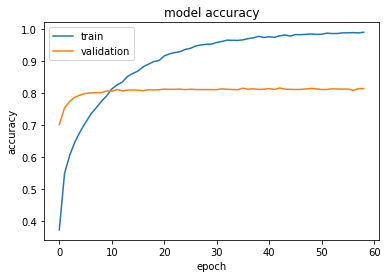

In [23]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES, bilinear=True, pca_list=pca_list)

epochs = 200  # @param {type: "slider", min:2, max:200}
model.summary()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, 
                callbacks=[early_stopping], verbose=2)
plot_hist(hist)

In [24]:
_, pca_accuracy_train =  model.evaluate(ds_train)
_, pca_accuracy_test =  model.evaluate(ds_test)

67/67 [==============================] - 19s 273ms/step - loss: 0.6159 - accuracy: 0.8122


In [25]:
# print('Accuracy for Generic Top, Training/Testing\n\t', generic_accuracy_train, '\n\t', generic_accuracy_test)
# print('Accuracy for Bilinear Top, Training/Testing\n\t', bilinear_accuracy_train, '\n\t', bilinear_accuracy_test)
print('Accuracy for Bilinear PCA Top, Training/Testing\n\t', pca_accuracy_train, '\n\t', pca_accuracy_test)

Accuracy for Bilinear PCA Top, Training/Testing
	 0.9921035170555115 
	 0.8121501803398132
